In [1]:
# # # For quickly testing when working on external libraries
# %load_ext autoreload
# %autoreload 2

In [2]:
# First, the generic imports.
import sys, os, glob, time, pathlib
import numpy as np
import h5py as h5
import pandas as pd
import ROOT as rt # Mostly useful here for plotting
import matplotlib.pyplot as plt # Alternative plotting option
import uproot as ur
import awkward as ak
import subprocess as sub
from numba import jit
import argparse as ap # useful when converting to script

# Next, import our utilities. We define our "path_prefix" from where we can find them.
path_prefix = os.getcwd() + '/../'
if(path_prefix not in sys.path): sys.path.append(path_prefix)

from util import ml_util as mu # Data preparation and wrangling for our neural networks.
from util import qol_util as qu # Quality-of-life stuff, like plot styles and progress bars.
from util import jet_util as ju # Jet-specific utilities, e.g. wrapping for FastJet & introducing our ML outputs to jet clustering.
from util import io_util as iu # Utilities for scaling regression input/output.

# Classification-specific utilities (network setup).
from util.classification import data_util as cdu
from util.classification import training_util as ctu # besides training, can be used to load network from file
import util.classification.models as classifier_models
import util.classification.models_exp as classifier_models_exp

# Regression-specific utilities (data-loading, network setup).
from util.regression import data_util as rdu
from util.regression import training_util as rtu # besides training, can be used to load network from file
import util.regression.models as regressor_models

# Jet-specific utilities (stuff to make this notebook simpler).
if(os.getcwd() not in sys.path): sys.path.append(os.getcwd())
from jet_util import jet_matching as jm
from data_util import data_util as du

Welcome to JupyROOT 6.24/02


2021-08-05 07:04:26.390851: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# ML4P for Jet Clustering

In this notebook, we'll use our topo-cluster classifiers and regressors to correct the energies of topo-clusters, and then cluster these topo-clusters into jets! The goal is to see how using these corrected energies (i.e. applying our ML stuff) affects the jet energy scale resolution.

## Setup

Let's start by defining some paths and model names for topo-cluster classification and regression -- we'll put these at the top so it's easy to switch things.

In [3]:
plotpath = os.getcwd() + '/Plots/'
data_dir = path_prefix + 'data/jet'

In [4]:
# Set up some plotting stuff.
plot_style = 'dark'
ps = qu.PlotStyle(plot_style)
ps.SetStyle() # will automatically affect ROOT plots from here on out, it sets ROOT.gStyle.
rt.gStyle.SetOptStat(0)

In [5]:
# Set up some calorimeter metadata.
# TODO: Get this from one of our libraries
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]
cell_shapes = {layers[i]:(len_eta[i],len_phi[i]) for i in range(len(layers))}

In [6]:
# Perform fastjet setup. This function will download & build fastjet if it isn't found at the given location.
fastjet_dir = path_prefix + 'fastjet'
fastjet_dir =  ju.BuildFastjet(fastjet_dir, j=8)
fastjet_dir = glob.glob('{}/**/site-packages'.format(fastjet_dir),recursive=True)[0]
if(fastjet_dir not in sys.path): sys.path.append(fastjet_dir)
import fastjet as fj
fj.ClusterSequence.print_banner() # Get the Fastjet banner out of the way

#--------------------------------------------------------------------------
#                         FastJet release 3.4.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code
# and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


## Data preparation

Let's also fetch our jet data. This is MC dijet data, so we have some light-quark jets to work with. The data contains information on topo-clusters for each event -- the same cell-level and cluster-level info we have with our network training data.

In [7]:
h5_name_suffix = 'jdata' # used for HDF5 files containing selected events

# We package things as a dictionary for now, since that's what our `setupPionData` function expects.
rootfiles = {'jet':glob.glob(data_dir + '/*.root')}
branches = [
            'clusterE', 'clusterECalib', 
            'clusterPt', 'clusterEta', 'clusterPhi', 
            #'cluster_nCells', 'cluster_sumCellE', 
            'cluster_ENG_CALIB_TOT'#, 'cluster_EM_PROBABILITY'
] 

In [8]:
# Prepare data
h5_name = '/'.join((data_dir,h5_name_suffix))

cluster_max_eta = 0.7
cluster_min_eng_calib_tot = 1.0e-10 # not used for "jdata"

pdata,pcells,sel_indices = mu.setupPionData(rootfiles,
                                            branches=branches,
                                            layers=layers,
                                            balance_data=False,
                                            verbose=True,
                                            load=True,
                                            save=True,
                                            filename=h5_name,
                                            cut_distributions=['cluster_ENG_CALIB_TOT','clusterEta'],
                                            cut_values = [cluster_min_eng_calib_tot, (-cluster_max_eta,cluster_max_eta)],
                                            cut_types=['lower','window'],
                                            return_indices=True
                                           )

# Get rid of one layers of keys, which is redundant in this case.
pdata = pdata['jet']
pcells = pcells['jet']
sel_indices = sel_indices['jet']

Loading pandas DataFrame and calo images from /local/home/jano/ml4pions/LCStudies/jets/../data/jet/jdata_frame.h5 and /local/home/jano/ml4pions/LCStudies/jets/../data/jet/jdata_images.h5.


We also want to fetch information on EM and LC jets. These are stored in trees called `EventTree` in our files.

In [9]:
reference_jet_names = ['AntiKt4EMTopoJets','AntiKt4LCTopoJets','AntiKt4TruthJets']
jet_component_names = ['Pt','Eta','Phi','E']
jet_branches = [x+y for x in reference_jet_names for y in jet_component_names]

jet_info = ur.lazy([':'.join((x,'EventTree')) for x in rootfiles['jet']],filter_branch=lambda x: x.name in jet_branches)

## Debugging

Instead of using our classifier + regressors, we will just use the true energy for the clusters. In other words, we'll pretend that our networks are performing perfectly, to see what would actually happen.

## Cluster kinematics

Since in this debugging notebook we are directly substituting the true cluster energy `cluster_ENG_CALIB_TOT` for the cluster reco energy `clusterE`, let's plot these variables.

Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/jets/Plots/energy_vs_calib_hits.png has been created


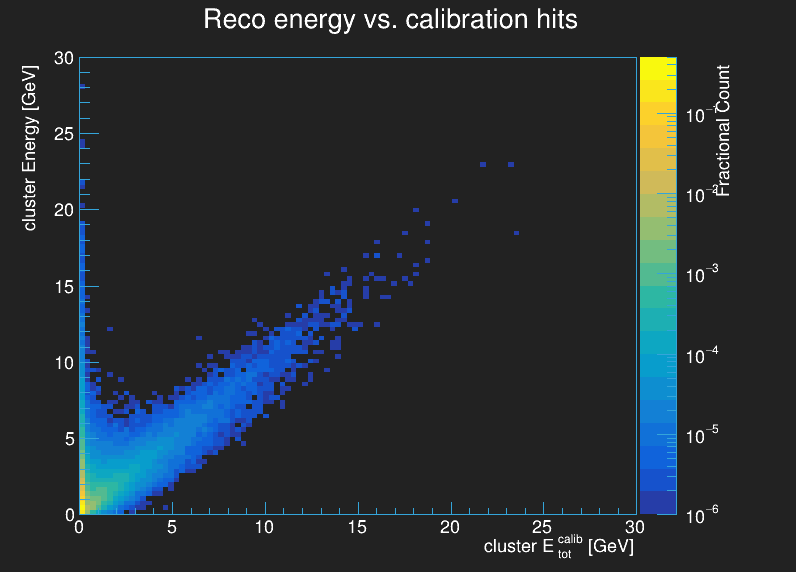

In [10]:
canvas = rt.TCanvas(qu.RN(),'c',800,600)
binning = (100,0.,30.)

h2d = rt.TH2F(qu.RN(), 'Reco energy vs. calibration hits;cluster E_{tot}^{calib} [GeV];cluster Energy [GeV];Fractional Count',
              *binning, *binning
             )

for entry in pdata[['cluster_ENG_CALIB_TOT','clusterE']].to_numpy():
    h2d.Fill(*entry)
        
# rescale our histograms
h2d.Scale(1./h2d.Integral())
h2d.Draw('COLZ')
rt.gPad.SetRightMargin(0.2)
rt.gPad.SetLogz()
h2d.SetMinimum(1.0e-6)
h2d.SetMaximum(5.0e-1)
canvas.Draw()
canvas.SaveAs(plotpath + 'energy_vs_calib_hits.png')

## Jet clustering

Now we want to cluster jets from our topo-clusters, using the predicted energies.

Jet clustering is performed at the *event level*, whereas our DataFrame `pdata` contains *cluster level* information, i.e. it does not have information on which event a particular cluster belongs to. However, we can fetch this information from the `EventTree` in the ROOT files.

Specifically, each `EventTree` has a branch called `clusterCount` that gives the index of the 1st cluster in the associated `ClusterTree` that belongs to that event -- which together with `nCluster` can be used to associate a set of clusters with a given event.

The only issue is that we're opening *multiple* trees at once and chaining them together in the DataFrame (via `uproot.lazy`, which is a little like `ROOT.TChain`). The `clusterCount` variable starts at 0 for every tree, so it gives the index with respect to the current tree but not with respect to the full DataFraame. This is however relatively easy to fix.

Furthermore, we have to consider that we have thrown out topo-clusters that didn't pass certain cuts -- so we have to be careful when converting from indices in the original ROOT files (that contain all topo-clusters) to indices in our DataFrame, that contains only filtered topo-clusters.

In [11]:
def GetGlobalClusterCount(cluster_count):
    n = len(cluster_count)
    for i in range(1,n):
        if(cluster_count[i] <= cluster_count[i-1]):
            cluster_count[i:] += cluster_count[i-1]
    return cluster_count

@jit
def SelectionsToFrameIndices(sel_indices):
    new_indices = np.full(sel_indices.shape, -1, dtype=np.dtype('i8'))
    counter = 0
    for i,idx in enumerate(sel_indices):
        if(idx):
            new_indices[i] = counter
            counter += 1
    return new_indices

In [12]:
cluster_idx_branches = ['clusterCount','nCluster']


cluster_event_info = ur.lazy([':'.join((x,'EventTree')) for x in rootfiles['jet']], 
                             filter_branch=lambda x: x.name in cluster_idx_branches
                            )

cluster_event_info = {key:cluster_event_info[key].to_numpy() for key in cluster_idx_branches}
cluster_event_info['clusterCount'] = GetGlobalClusterCount(cluster_event_info['clusterCount'])
nevents = cluster_event_info['clusterCount'].shape[0]

selected_frame_indices = SelectionsToFrameIndices(sel_indices)

In [13]:
# Define our jet clustering
jet_radius = 0.4
jet_def = fj.JetDefinition(fj.antikt_algorithm, jet_radius)

As we are working within some topo-cluster $\eta$ window cut, we only want to look at jets that are well within this window. The EM, LC and truth jets in our data will likely cover a larger $\eta$ range so we will want to remove these jets outside our $\eta$: Those outside the window can't be matched to our ML jets, and keeping them will make the jets' kinematic distributions look quite different.

In fact, we also want to throw out any jets *near* our $\eta$ window cut edge, as this cut might affect jet clustering of jets that are very close to the cut.

In [14]:
jet_max_eta = cluster_max_eta - jet_radius

In [15]:
# Create variables for saving information on the jets we cluster.
custom_jet_name = 'AntiKt4RefTopoJets'
custom_jet_keys = [custom_jet_name + x for x in jet_component_names]
custom_jet_info = {key:[] for key in custom_jet_keys}

# # Debugging: Also recreate the EM jets, using the raw topo-cluster info
# debug_jet_keys = ['AntiKt4EMTopoJets{}'.format(x) for x in ['Pt','Eta','Phi','E']]
# debug_jet_info = {key:[] for key in debug_jet_keys}

# Keep track of indices of events that have clusters passing cuts (some might not).
selected_event_indices = np.arange(nevents)

# Create a progress bar. We include some timing to prevent problems with
# the progress bar update speed outstripping the JupyterLab update rate. (IOPub issues).
prefix = 'Clustering Ref jets:'
suffix = '% Complete'
length = 40
qu.printProgressBarColor (0, nevents, prefix=prefix, suffix=suffix, length=length)
prev_time = time.time()
dt = 0.25

# Event loop
for i in range(nevents):
    print_progress = False
    if(i % 100 == 0):
        if(time.time() - prev_time > dt): print_progress = True
    elif(i == nevents-1): 
        time.sleep(dt)
        print_progress = True
        
    # Determine which clusters from pdata belong to this event.
    cluster_idx_start = cluster_event_info['clusterCount'][i]
    nCluster = cluster_event_info['nCluster'][i]
    cluster_idx_end = cluster_idx_start + nCluster # not included!
    
    cluster_indices = selected_frame_indices[cluster_idx_start:cluster_idx_end]
    cluster_indices = cluster_indices[cluster_indices >= 0]  
    
    # Check if there are no clusters passing cuts in this event -- if so, we skip it.
    if(len(cluster_indices) == 0):
        selected_event_indices[i] = -1
        if(print_progress): qu.printProgressBarColor (i+1, nevents, prefix=prefix, suffix=suffix, length=length)
        continue
    
    # Gather the cluster components
    clusterE = pdata['cluster_ENG_CALIB_TOT'][cluster_indices].to_numpy()
    #clusterE = pdata[predicted_energy_key][cluster_indices].to_numpy()    
    clusterE_old = pdata['clusterE'][cluster_indices].to_numpy()
    clusterPt = pdata['clusterPt'][cluster_indices].to_numpy() * clusterE / clusterE_old # adjust the clusterPt using the new energy, to keep things physical
    clusterEta = pdata['clusterEta'][cluster_indices].to_numpy()
    clusterPhi = pdata['clusterPhi'][cluster_indices].to_numpy()
        
    # Convert to Cartesian, which we need for FastJet. Returns format (px, py, pz, E).
    cartesian_vectors = ju.Polar2Cartesian(clusterPt, clusterEta, clusterPhi, clusterE)
    
    # Create PseudoJet objects.
    pseudojets = [fj.PseudoJet(*x) for x in cartesian_vectors]
    
    # Cluster PseudoJets.
    cs = fj.ClusterSequence(pseudojets, jet_def)
    jets = cs.inclusive_jets()
    njets = len(jets)
    
#     jets = jet_def(pseudojets) # this is equivalent, see the FastJet python examples (also is empirically the same)
#     njets = len(jets)
    
    # Extract the jet 4-vector components, and put them in custom_jet_info.
    # FastJet gives phi in (0, 2π) whereas our reference jets use (-π,π), so we will shift things.
    jet_vectors = np.array([[x.pt(), x.eta(), x.phi() - np.pi, x.e()] for x in jets])
    
    for j,key in enumerate(custom_jet_info.keys()):
        custom_jet_info[key].append(jet_vectors[:,j])

    if(print_progress): qu.printProgressBarColor (i+1, nevents, prefix=prefix, suffix=suffix, length=length)
    
# Now keep only indices of events where we had any jets to cluster.
# (Some events may have only had topo-clusters outside of our eta window or below our minimum energy cut).
selected_event_indices = selected_event_indices[selected_event_indices >= 0]
print('Created Ref jets for {:.2f}% of events. Events without ML jets may not have had topo-clusters passing our cuts.'.format(100. * len(selected_event_indices) / nevents))

Clustering Ref jets: |████████████████████████████████████████| 100.0% % Complete
Created Ref jets for 43.16% of events. Events without ML jets may not have had topo-clusters passing our cuts.


In [16]:
# Adjust jet_info. Writing it this way to avoid wonkiness when re-running notebook cells.
if(len(selected_event_indices) != len(jet_info)):
    jet_info = jet_info[selected_event_indices]

Let's create our filtered jet info, with only jets well within our topo-cluster eta window.

In [17]:
filtered_jet_info = {}
jet_names = reference_jet_names + [custom_jet_name]

nevents = len(jet_info)
prefix = 'Filtering jets:'
suffix = '% Complete'
length = 40
qu.printProgressBarColor (0, 4 * nevents, prefix=prefix, suffix=suffix, length=length)

for jname in jet_names:
    for jcomp in jet_component_names:
        key = jname + jcomp
        filtered_jet_info[key] = []

# First add our filtered "reference" jets (EM, LC, Truth)
for i,jname in enumerate(reference_jet_names):
    for j in range(nevents):
        eta = jet_info[jname + 'Eta'][j].to_numpy()
        sel = np.abs(eta) < jet_max_eta
        
        for jcomp in jet_component_names:
            key = jname + jcomp
            x = jet_info[key][j].to_numpy()[sel]
            filtered_jet_info[key].append(x) 
        if(j%10==0 or j==nevents-1): qu.printProgressBarColor (i * nevents + j + 1, 4 * nevents, prefix=prefix, suffix=suffix, length=length)
        
# Now add our filtered ML jets.
for i in range(nevents):
    eta = custom_jet_info[custom_jet_name + 'Eta'][i]
    sel = np.abs(eta) < jet_max_eta
    
    for jcomp in jet_component_names:
        key = custom_jet_name + jcomp
        x = custom_jet_info[key][i][sel]
        filtered_jet_info[key].append(x)
    if(i%10==0 or i==nevents-1): qu.printProgressBarColor (3 * nevents + i + 1, 4 * nevents, prefix=prefix, suffix=suffix, length=length)

Filtering jets: |████████████████████████████████████████| 100.0% % Complete


Note that our reference jets (EM, LC, Truth) have their transverse momentum and energy stored in MeV, whereas our Ref jets have these variables stored in GeV (since the cluster-level info was in GeV and we didn't convert it to MeV before clustering).

To keep everything internally consistent, we will convert our reference jets to GeV.

In [18]:
for jname in reference_jet_names:
    for comp_name in ['Pt','E']:
        assert(comp_name in jet_component_names) # safety check in case someone changes component names
        key = jname + comp_name
        for i in range(len(filtered_jet_info[key])):
            filtered_jet_info[key][i] /= 1000.    

## Some initial jet plotting

At this point, we've created our Ref jets. We still haven't performed any jet matching, but let's take a glance at some distributions.

In [19]:
colors = [rt.kGreen, rt.kViolet-4, rt.kRed, ps.curve]

# some stuff from our normal workflow -- names not really relevant here
regressor_modelname = 'reference'
score_cut_string = ''

In [20]:
# Create a TPaveText with cuts.

cut_text = [
    '|#eta_{jet}|' + ' < {:.1f}'.format(jet_max_eta),
    '|#eta_{cluster}|' + ' < {:.1f}'.format(cluster_max_eta)
]

cut_box = rt.TPaveText(0.7,0.5,0.9,0.75, 'NDC')
cut_box.SetTextColor(ps.text)
cut_box.SetBorderSize(1)
cut_box.SetFillColorAlpha(ps.canv,0.5)
cut_box.SetTextSize(3e-2)


for text in cut_text:
    cut_box.AddText(text)

Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/jets/Plots/jet_kin_reference_.png has been created


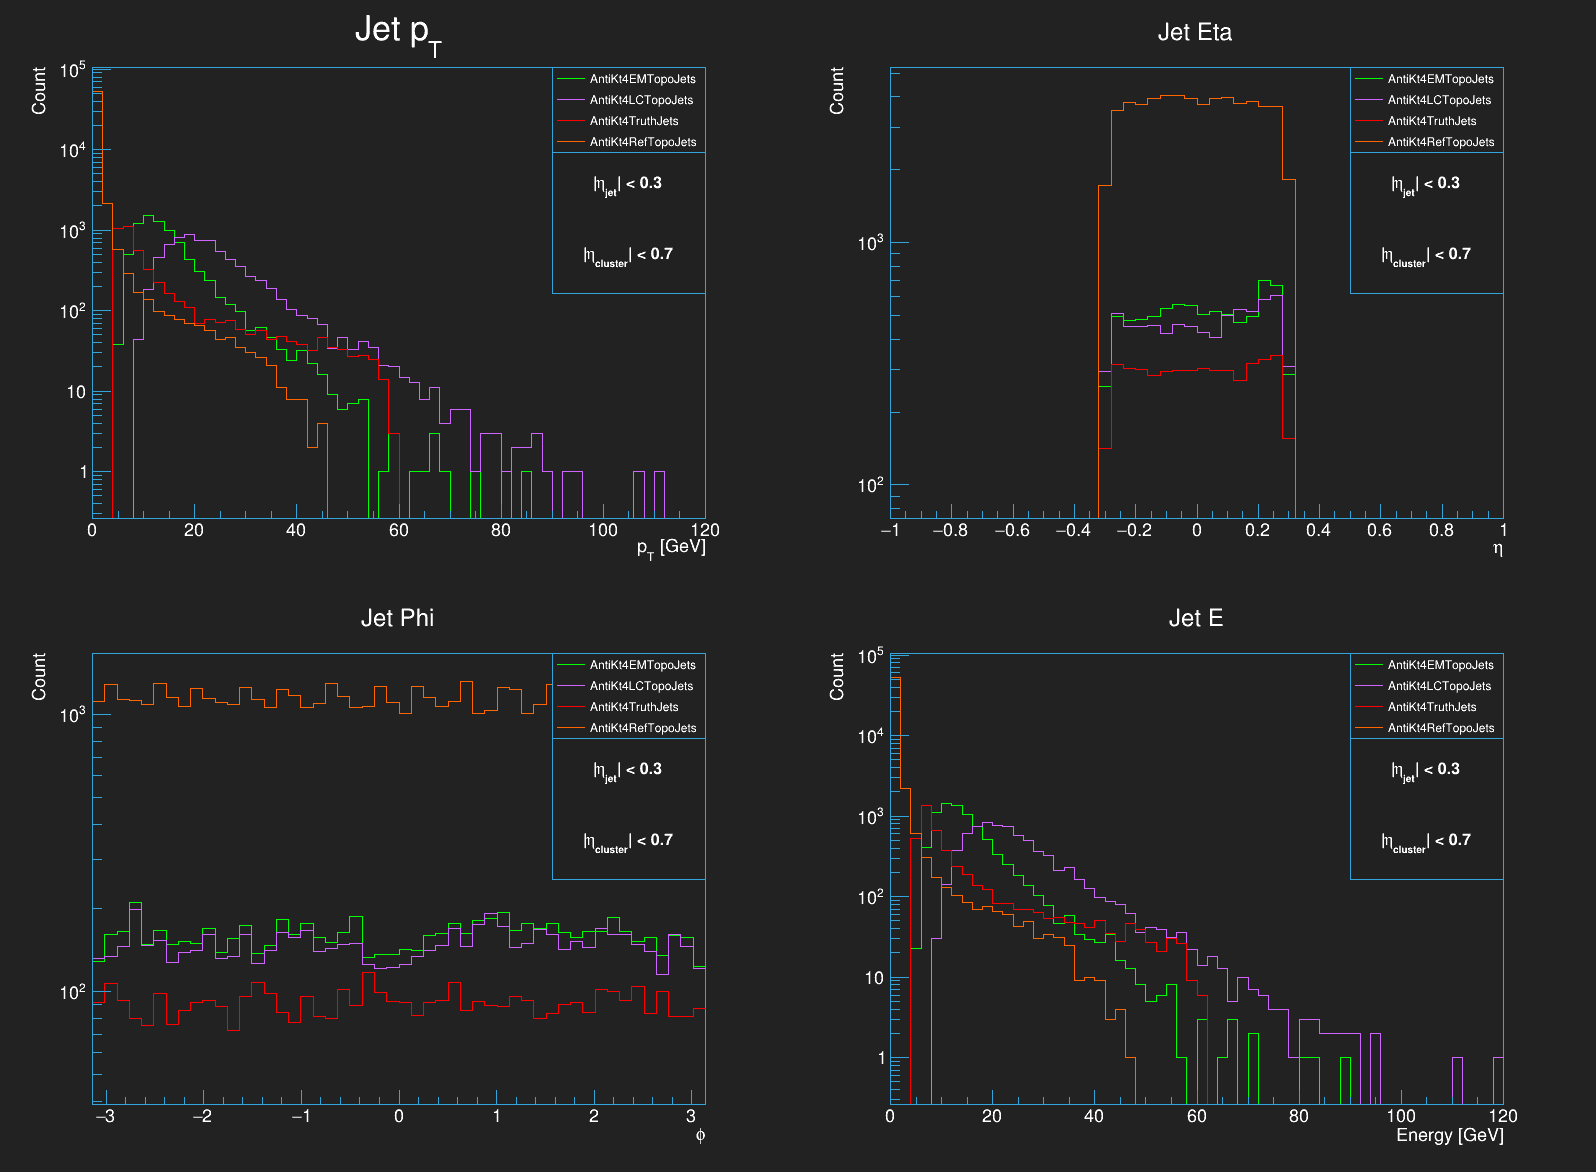

In [21]:
c = rt.TCanvas(qu.RN(),'',1600,1200)
hists = []
stacks = []
c.Divide(2,2)

c.cd(1)
leg = rt.TLegend(0.7,0.75,0.9,0.9)
leg.SetTextColor(ps.text)
hstack = rt.THStack(qu.RN(),'Jet p_{T};p_{T} [GeV];Count')

for i,jname in enumerate(jet_names):
    
    x = np.concatenate(filtered_jet_info[jname + 'Pt'])
    h = rt.TH1F(qu.RN(),'',60,0.,120.)
    for entry in x:
        h.Fill(entry)
    #h.Scale(1./h.Integral())
    h.SetLineColor(colors[i])
    hstack.Add(h)
    hists.append(h)
    leg.AddEntry(h,jname,'l')
    
hstack.Draw('NOSTACK HIST')
leg.Draw()
cut_box.Draw()
rt.gPad.SetLogy()
stacks.append(hstack)

c.cd(2)
hstack = rt.THStack(qu.RN(),'Jet Eta;#eta;Count')
for i,jname in enumerate(jet_names):
    
    x = np.concatenate(filtered_jet_info[jname + 'Eta'])
    h = rt.TH1F(qu.RN(),'',50,-1.,1.)
    for entry in x:
        h.Fill(entry)
    #h.Scale(1./h.Integral())
    h.SetLineColor(colors[i])
    hstack.Add(h)
    hists.append(h)
    
hstack.Draw('NOSTACK HIST')
leg.Draw()
cut_box.Draw()
rt.gPad.SetLogy()
stacks.append(hstack)

c.cd(3)
hstack = rt.THStack(qu.RN(),'Jet Phi;#phi;Count')
for i,jname in enumerate(jet_names):
    
    x = np.concatenate(filtered_jet_info[jname + 'Phi'])
    h = rt.TH1F(qu.RN(),'',50, -np.pi, np.pi)
    for entry in x:
        h.Fill(entry)
    #h.Scale(1./h.Integral())
    h.SetLineColor(colors[i])
    hstack.Add(h)
    hists.append(h)
    
hstack.Draw('NOSTACK HIST')
leg.Draw()
cut_box.Draw()
rt.gPad.SetLogy()
stacks.append(hstack)

c.cd(4)
hstack = rt.THStack(qu.RN(),'Jet E;Energy [GeV];Count')
for i,jname in enumerate(jet_names):
    
    x = np.concatenate(filtered_jet_info[jname + 'E'])
    h = rt.TH1F(qu.RN(),'',60,0.,120.)
    for entry in x:
        h.Fill(entry)
    #h.Scale(1./h.Integral())
    h.SetLineColor(colors[i])
    hstack.Add(h)
    hists.append(h)
    
hstack.Draw('NOSTACK HIST')
leg.Draw()
cut_box.Draw()
rt.gPad.SetLogy()
stacks.append(hstack)

c.Draw()
c.SaveAs(plotpath+'jet_kin_{}_{}.png'.format(regressor_modelname,score_cut_string))

Interestingly, the energy distribution of our reference jets -- where we've used the true topo-cluster energies -- looks quite different than all the others.

## Jet Matching

Now, we have to perform jet matching, specifically:
- Match `AntiKt4EMTopoJets` to `AntiKt4TruthJets`
- Match `AntiKt4LCTopoJets` to `AntiKt4TruthJets`
- Match `AntiKt4RefTopoJets` to `AntiKt4TruthJets`

Once we have matched jets, we can compute the jet energy response.

To perform matching, we will use some (slightly modified) code from the [GepJetMatching package](https://gitlab.cern.ch/jaofferm/gepjetmatching). This already implements the ATLAS jet matching algorithm so we don't have to re-invent the wheel. The only issue is that we will have to save our current jets to a ROOT file (with a somewhat particular format) and its output will also be a ROOT file.

In [22]:
# Saving our jets to a file.
jet_file = 'jets_{}.root'.format(score_cut_string)
tree_name = 'ntuple' # name must be "ntuple", this is used internally by GepJetMatching
f = rt.TFile(jet_file,'RECREATE')
t = rt.TTree(tree_name,tree_name) 

branches = {}
buffers = {}
for key in filtered_jet_info.keys():
    buffers[key] = rt.std.vector('double')()
    branches[key] = t.Branch(key,buffers[key])
    
nevents = len(jet_info) # redundant, just for safety
for i in range(nevents):  
    for buffer in buffers.values(): buffer.clear()
    for key,vals in filtered_jet_info.items():
        for val in vals[i]: buffers[key].push_back(val)      
    t.Fill()
t.Write()
f.Close()

In [23]:
# Now we want to match each reco jet (EM, LC, ML) to truth.
match_settings = {
    'pt_min':5.0, # here in GeV 7.0
    'eta_max':4.5,
    'requirePileupCheck':True, # TODO: turn on if we have pileup
    'requireIsoReco':True,
    'requireIsoTruth':True,
    'dr':0.3,
    'truth_iso_dr':0.3,
    'reco_iso_dr':0.3
}

reco_jets = [x for x in jet_names if 'Truth' not in x]
truth_jet = 'AntiKt4TruthJets'
matches = ['{}->{}'.format(x,truth_jet) for x in reco_jets]
matched_jet_files = {
    key: '{}_{}_{}.root'.format(key,regressor_modelname, score_cut_string)
    for key in reco_jets
}

In [24]:
executable_suffix = 'jet_util/' # relative location of JetMatching.C, our ROOT C++ macro for jet matching
for i,reco_jet in enumerate(reco_jets):
    print('Matching {}.'.format(matches[i]))
    jm.MatchJets(matches[i], match_settings, [jet_file], matched_jet_files[reco_jet],executable_suffix)

# Delete files created by our jet matching macro compilation
jet_compilation_files = []
for extension in ['d','pcm']:
    jet_compilation_files += glob.glob(os.getcwd() + '/' + executable_suffix + '*.{}'.format(extension))
for file in jet_compilation_files:
    command = ['rm', file]
    sub.check_call(command)

Matching AntiKt4EMTopoJets->AntiKt4TruthJets.
Matching AntiKt4LCTopoJets->AntiKt4TruthJets.
Matching AntiKt4RefTopoJets->AntiKt4TruthJets.


Now that we have ROOT files containing matched jets, let's open them with `uproot`. With these, we can easily compute the energy response. We'll also plot the kinematics of our matched jets.

In [25]:
matched_jet_trees = {
    key:ur.open(val)[tree_name]
    for key,val in matched_jet_files.items()
}

In [26]:
colors = [rt.kGreen, rt.kViolet-4, ps.curve]

Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/jets/Plots/jet_kin_matched_reference_.png has been created


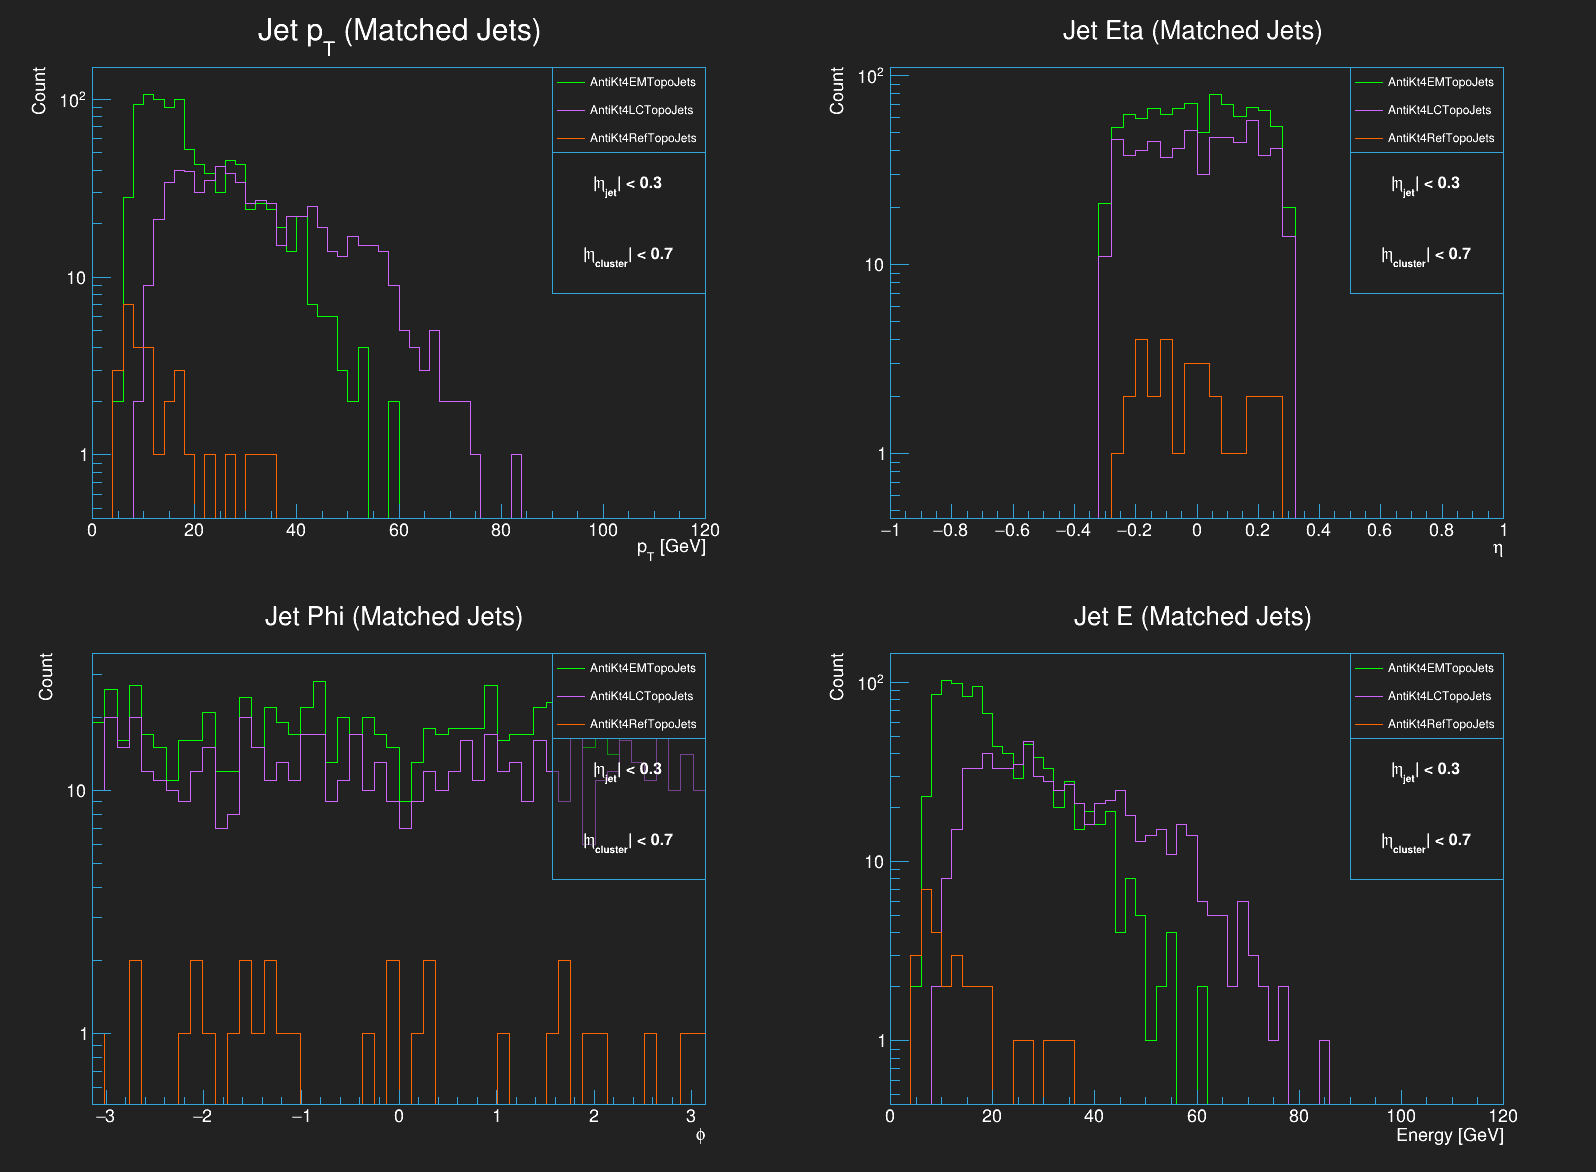

In [27]:
c = rt.TCanvas(qu.RN(),'',1600,1200)
hists = []
stacks = []
c.Divide(2,2)

c.cd(1)
leg = rt.TLegend(0.7,0.75,0.9,0.9)
leg.SetTextColor(ps.text)
hstack = rt.THStack(qu.RN(),'Jet p_{T} (Matched Jets);p_{T} [GeV];Count')

for i,reco_jet in enumerate(reco_jets):
    x = ak.flatten(matched_jet_trees[reco_jet][reco_jet + 'Pt'].array()).to_numpy()
    h = rt.TH1F(qu.RN(),'',60,0.,120.)
    for entry in x:
        h.Fill(entry)
    #h.Scale(1./h.Integral())
    h.SetLineColor(colors[i])
    hstack.Add(h)
    hists.append(h)
    leg.AddEntry(h,reco_jet,'l')
    
hstack.Draw('NOSTACK HIST')
leg.Draw()
cut_box.Draw()
rt.gPad.SetLogy()
stacks.append(hstack)

c.Draw()

c.cd(2)
hstack = rt.THStack(qu.RN(),'Jet Eta (Matched Jets);#eta;Count')
for i,reco_jet in enumerate(reco_jets):
    x = ak.flatten(matched_jet_trees[reco_jet][reco_jet + 'Eta'].array()).to_numpy()
    h = rt.TH1F(qu.RN(),'',50,-1.,1.)
    for entry in x:
        h.Fill(entry)
    #h.Scale(1./h.Integral())
    h.SetLineColor(colors[i])
    hstack.Add(h)
    hists.append(h)
    
hstack.Draw('NOSTACK HIST')
leg.Draw()
cut_box.Draw()
rt.gPad.SetLogy()
stacks.append(hstack)

c.cd(3)
hstack = rt.THStack(qu.RN(),'Jet Phi (Matched Jets);#phi;Count')
for i,reco_jet in enumerate(reco_jets):
    x = ak.flatten(matched_jet_trees[reco_jet][reco_jet + 'Phi'].array()).to_numpy()
    h = rt.TH1F(qu.RN(),'',50, -np.pi, np.pi)
    for entry in x:
        h.Fill(entry)
    #h.Scale(1./h.Integral())
    h.SetLineColor(colors[i])
    hstack.Add(h)
    hists.append(h)
    
hstack.Draw('NOSTACK HIST')
leg.Draw()
cut_box.Draw()
rt.gPad.SetLogy()
stacks.append(hstack)

c.cd(4)
hstack = rt.THStack(qu.RN(),'Jet E (Matched Jets);Energy [GeV];Count')
for i,reco_jet in enumerate(reco_jets):
    x = ak.flatten(matched_jet_trees[reco_jet][reco_jet + 'E'].array()).to_numpy()
    h = rt.TH1F(qu.RN(),'',60,0.,120.)
    for entry in x:
        h.Fill(entry)
    #h.Scale(1./h.Integral())
    h.SetLineColor(colors[i])
    hstack.Add(h)
    hists.append(h)
    
hstack.Draw('NOSTACK HIST')
leg.Draw()
cut_box.Draw()
rt.gPad.SetLogy()
stacks.append(hstack)

c.Draw()
c.SaveAs(plotpath+'jet_kin_matched_{}_{}.png'.format(regressor_modelname, score_cut_string))

Let's get the energy response. To be specific, we are interested in the response in *transverse* energy, $E_T$.

In [28]:
energy_response = {}

In [29]:
for reco_jet in reco_jets:
    reco_energy = ak.flatten(matched_jet_trees[reco_jet][reco_jet + 'E'].array()).to_numpy()
    truth_energy = ak.flatten(matched_jet_trees[reco_jet][truth_jet + 'E'].array()).to_numpy()
    
    reco_eta = ak.flatten(matched_jet_trees[reco_jet][reco_jet + 'Eta'].array()).to_numpy()
    truth_eta = ak.flatten(matched_jet_trees[reco_jet][truth_jet + 'Eta'].array()).to_numpy()

    reco_et = reco_energy / np.cosh(reco_eta)
    truth_et = truth_energy / np.cosh(truth_eta)

    energy_response[reco_jet] = reco_et / truth_et
    print(reco_jet, len(reco_et))

AntiKt4EMTopoJets 929
AntiKt4LCTopoJets 628
AntiKt4RefTopoJets 30


Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/jets/Plots/response_reference_.png has been created


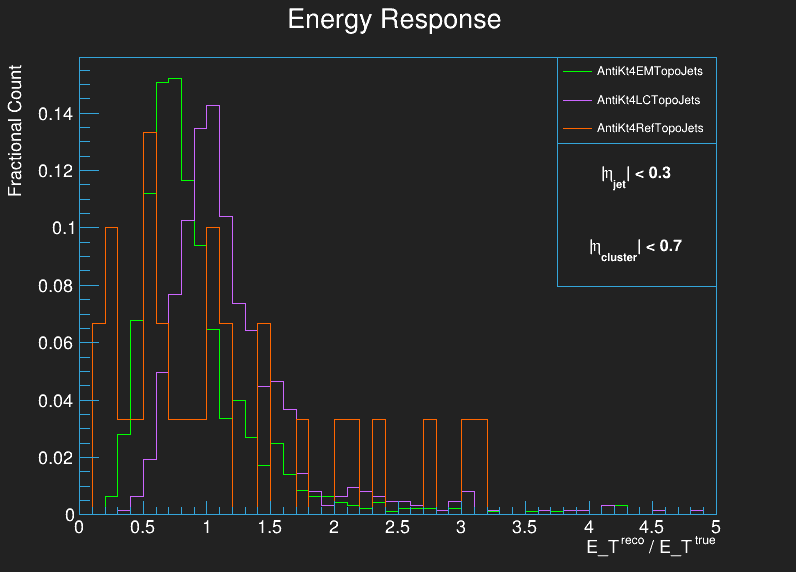

In [30]:
c = rt.TCanvas(qu.RN(), 'c', 800, 600)
hstack = rt.THStack(qu.RN(),'Energy Response;E_T^{reco} / E_T^{true};Fractional Count')
binning = (50,0.,5.)
for i,reco_jet in enumerate(reco_jets):
    h = rt.TH1F(qu.RN(),'',*binning)
    for entry in energy_response[reco_jet]: h.Fill(entry)
    h.Scale(1./h.Integral())
    h.SetLineColor(colors[i])
    hists.append(h)
    hstack.Add(h)
hstack.Draw('NOSTACK HIST')
leg.Draw()
cut_box.Draw()
c.Draw()
c.SaveAs(plotpath+'response_{}_{}.png'.format(regressor_modelname,score_cut_string))

Two things stand out -- we have almost none of our reference jets (i.e. assigning the true energies to the topo-clusters seems to have prevented most jets from passing cuts), and the response, if it's even meaningful for such a small number of jets, is kind of all over the place.

Now let's look at the response of our Ref jets as a function of their kinematics.

In [31]:
# First, some simple variables

pt = ak.flatten(matched_jet_trees[custom_jet_name][custom_jet_name + 'Pt'].array()).to_numpy()
eta = ak.flatten(matched_jet_trees[custom_jet_name][custom_jet_name + 'Eta'].array()).to_numpy()
phi = ak.flatten(matched_jet_trees[custom_jet_name][custom_jet_name + 'Phi'].array()).to_numpy()
e = ak.flatten(matched_jet_trees[custom_jet_name][custom_jet_name + 'E'].array()).to_numpy()

In [32]:
# Let's calculate the dR between each ML jet and its matched truth jet
from jet_util import calcs
eta_truth = ak.flatten(matched_jet_trees[custom_jet_name][truth_jet + 'Eta'].array()).to_numpy()
phi_truth = ak.flatten(matched_jet_trees[custom_jet_name][truth_jet + 'Phi'].array()).to_numpy()
dr_truth = np.sqrt(np.array([calcs.DeltaR2(eta[i],phi[i],eta_truth[i],phi_truth[i]) for i in range(len(eta))]))

In [33]:
# Let's also calculate the dR between each ML jet and the nearest *other* ML jet
# TODO

Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/jets/Plots/kin_vs_response_reference_.png has been created


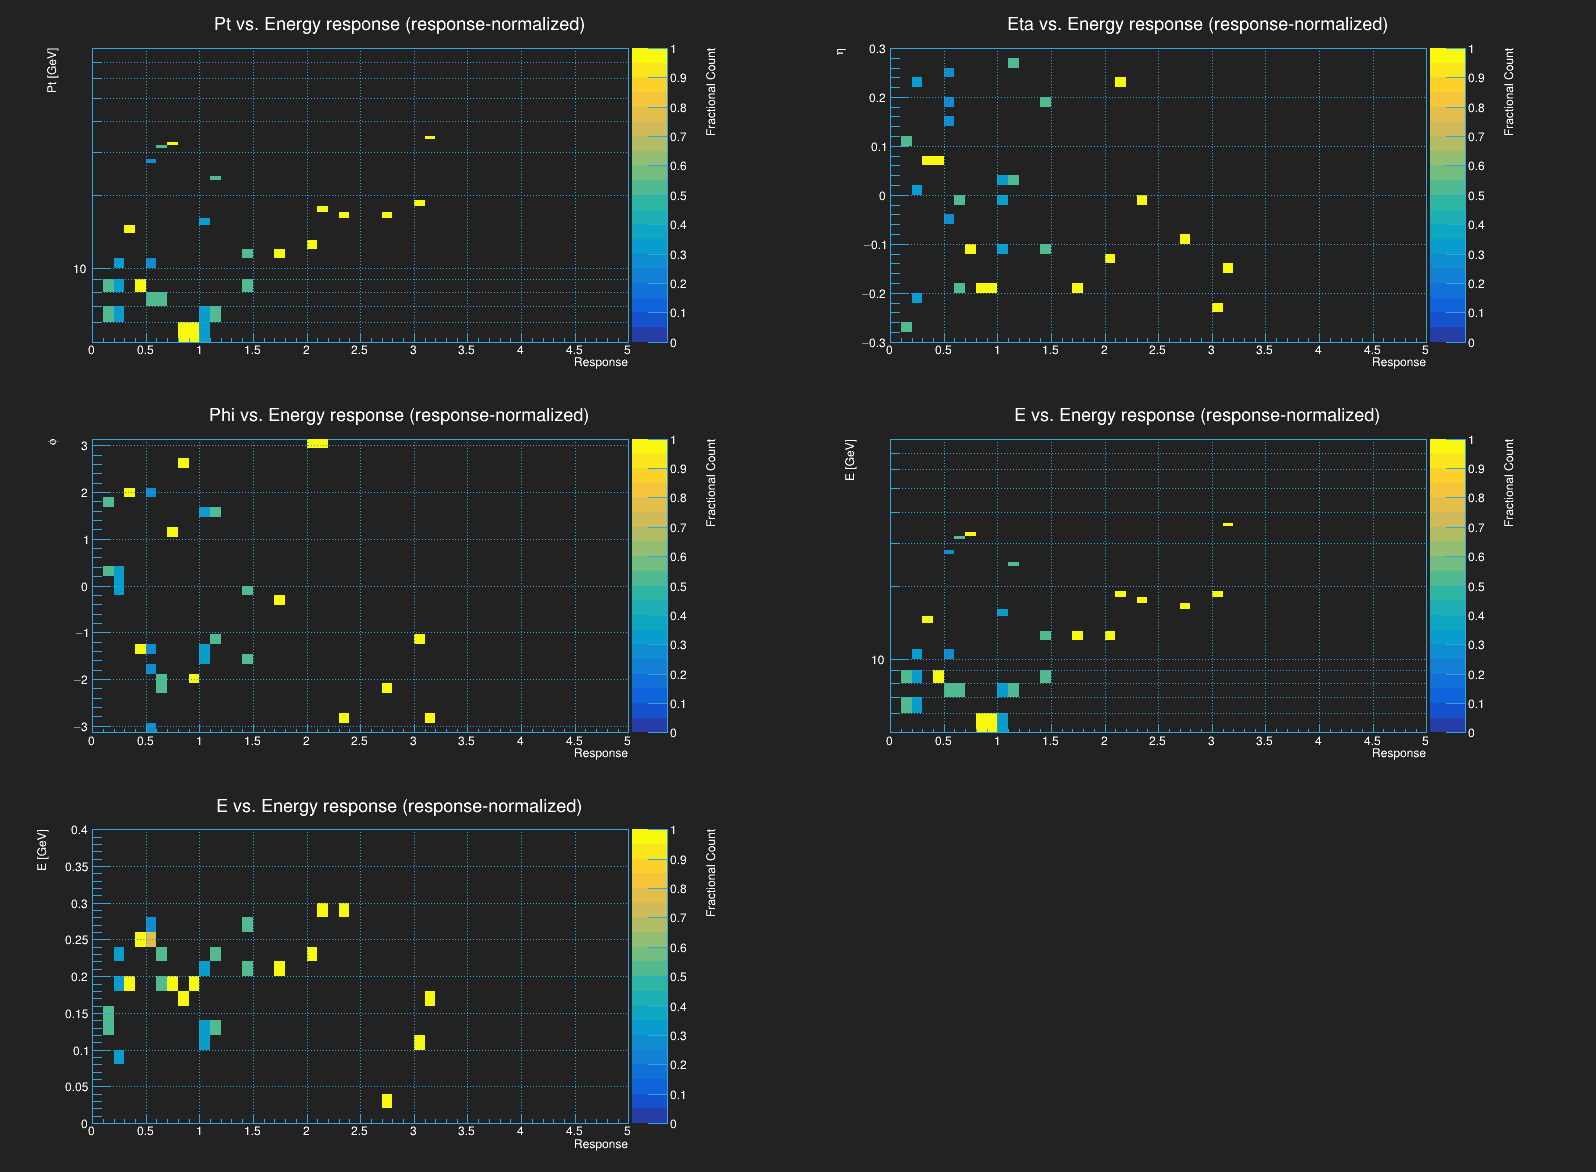

In [34]:
draw_option = 'COLZ'

c = rt.TCanvas(qu.RN(),'',1600,1200)
c.Divide(2,3)

binning_x = [50,0.,5.]

binning = {
    'Pt' :binning_x + [75,5.,80.],
    'Eta':binning_x + [30,-0.3,0.3],
    'Phi':binning_x + [30, -np.pi, np.pi],
    'E'  :binning_x + [75,5.,80.],
    'dr_truth': binning_x + [20,0.,0.4]
}

c.cd(1)
key = 'Pt'
h = rt.TH2F(qu.RN(),'Pt vs. Energy response (response-normalized);Response;Pt [GeV];Fractional Count', *binning[key])
for i in range(len(pt)):
    h.Fill(energy_response[custom_jet_name][i],pt[i])
    
# Normalize so that each response bin (x axis) integrates to 1
for i in range(binning_x[0]):
    total = 0.
    for j in range(binning[key][3]):
        total += h.GetBinContent(i+1,j+1) 
    if(total != 0.):
        for j in range(binning[key][3]):
            h.SetBinContent(i+1, j+1, h.GetBinContent(i+1,j+1) / total)

h.Draw(draw_option)
rt.gPad.SetRightMargin(0.2)
rt.gPad.SetLogy()
rt.gPad.SetGrid()
hists.append(h)

c.cd(2)
key = 'Eta'
h = rt.TH2F(qu.RN(),'Eta vs. Energy response (response-normalized);Response;#eta;Fractional Count', *binning[key])
for i in range(len(pt)):
    h.Fill(energy_response[custom_jet_name][i],eta[i])

# Normalize so that each response bin (x axis) integrates to 1
for i in range(binning_x[0]):
    total = 0.
    for j in range(binning[key][3]):
        total += h.GetBinContent(i+1,j+1) 
    if(total != 0.):
        for j in range(binning[key][3]):
            h.SetBinContent(i+1, j+1, h.GetBinContent(i+1,j+1) / total)
    
h.Draw(draw_option)
rt.gPad.SetRightMargin(0.2)
rt.gPad.SetGrid()
hists.append(h)

c.cd(3)
key = 'Phi'
h = rt.TH2F(qu.RN(),'Phi vs. Energy response (response-normalized);Response;#phi;Fractional Count', *binning[key])
for i in range(len(phi)):
    h.Fill(energy_response[custom_jet_name][i],phi[i])

    # Normalize so that each response bin (x axis) integrates to 1
for i in range(binning_x[0]):
    total = 0.
    for j in range(binning[key][3]):
        total += h.GetBinContent(i+1,j+1) 
    if(total != 0.):
        for j in range(binning[key][3]):
            h.SetBinContent(i+1, j+1, h.GetBinContent(i+1,j+1) / total)

h.Draw(draw_option)
rt.gPad.SetRightMargin(0.2)
rt.gPad.SetGrid()
hists.append(h)

c.cd(4)
key = 'E'
h = rt.TH2F(qu.RN(),'E vs. Energy response (response-normalized);Response;E [GeV];Fractional Count', *binning[key])
for i in range(len(e)):
    h.Fill(energy_response[custom_jet_name][i],e[i])

    # Normalize so that each response bin (x axis) integrates to 1
for i in range(binning_x[0]):
    total = 0.
    for j in range(binning[key][3]):
        total += h.GetBinContent(i+1,j+1) 
    if(total != 0.):
        for j in range(binning[key][3]):
            h.SetBinContent(i+1, j+1, h.GetBinContent(i+1,j+1) / total)

h.Draw(draw_option)
rt.gPad.SetRightMargin(0.2)
rt.gPad.SetLogy()
rt.gPad.SetGrid()
hists.append(h)

c.cd(5)
key = 'dr_truth'
h = rt.TH2F(qu.RN(),'E vs. Energy response (response-normalized);Response;E [GeV];Fractional Count', *binning[key])
for i in range(len(e)):
    h.Fill(energy_response[custom_jet_name][i],dr_truth[i])

    # Normalize so that each response bin (x axis) integrates to 1
for i in range(binning_x[0]):
    total = 0.
    for j in range(binning[key][3]):
        total += h.GetBinContent(i+1,j+1) 
    if(total != 0.):
        for j in range(binning[key][3]):
            h.SetBinContent(i+1, j+1, h.GetBinContent(i+1,j+1) / total)

h.Draw(draw_option)
rt.gPad.SetRightMargin(0.2)
rt.gPad.SetGrid()
hists.append(h)

c.Draw()
c.SaveAs(plotpath+'kin_vs_response_{}_{}.png'.format(regressor_modelname,score_cut_string))

In [35]:
# if __name__ == '__main__':
#     main(sys.argv)